In [10]:
from functools import reduce
from itertools import islice
import math
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# from hyperspherical_vae.distributions import VonMisesFisher, HypersphericalUniform

%matplotlib inline

In [2]:
def shuffle(*dfs):
  dataset = reduce(lambda a,b: np.append(a, b, axis=0), dfs)
  permutation = np.random.permutation(dataset.shape[0])
  shuffled = dataset[permutation]
  return shuffled


unit = 0.15

on = unit * 0.1
off = unit * 0.00


def generate_cluster(unit, cross_cov, mu, count):
    mu = np.array(mu)
    sigma_1, sigma_2, sigma_3 = unit, unit, unit
    sigma_1_2, sigma_1_3, sigma_2_3 = cross_cov
    cov = np.array([
      [sigma_1, sigma_1_2, sigma_1_3],
      [sigma_1_2, sigma_2, sigma_2_3],
      [sigma_1_3, sigma_2_3, sigma_3]
    ])
    ds = np.random.multivariate_normal(mu, cov, count)
    return ds


def reduce_correlation(ds, noise):
    count = ds.shape[0]
    ds_t = ds.T
    for i, x in enumerate(noise):
        num = int(count*x)
        ds_t[i].put(np.random.choice(count, num, replace=False), np.random.choice(ds.T[i], num))
    return ds_t.T


rv1 = generate_cluster(unit, (on, -off, off), [2,0,0], 250000) 
rv2 = generate_cluster(unit, (on, off, -off), [0,0,2], 500000)
rv3 = generate_cluster(unit, (-on, off, off), [0,2,0], 500000)
rv4 = generate_cluster(unit, (-on, -off, -off), [-1,-1,-1], 1000000)

# rv5 = generate_cluster(unit, (on, -off, off), [0,0,2], 1250000)
# rv6 = generate_cluster(unit, (-on, off, -off), [0,2,0], 1000000)
# 
# data = np.append(shuffle(rv1, rv2, rv3, rv4), shuffle(rv5, rv6), axis=1)

data = reduce(lambda a,b: np.append(a, b, axis=0), [rv1, rv2, rv3, rv4])

# ind_var = np.random.uniform(-1, 1, [data.shape[0], 20])

# data = np.append(data, ind_var, axis=1)

data = shuffle(data)

# data = reduce_correlation(data, [0.75, 0.75, 0.75])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.83130242, -2.7004229 , -2.56954339, -2.43866387, -2.30778436,
        -2.17690484, -2.04602532, -1.91514581, -1.78426629, -1.65338678,
        -1.52250726, -1.39162775, -1.26074823, -1.12986872, -0.9989892 ,
        -0.86810968, -0.73723017, -0.60635065, -0.47547114, -0.34459162,
        -0.21371211, -0.08283259,  0.04804692,  0.17892644,  0.30980595,
         0.44068547,  0.57156499,  0.7024445 ,  0.83332402,  0.96420353,
         1.09508305,  1.22596256,  1.35684208,  1.48772159,  1.61860111,
         1.74948063,  1.88036014,  2.01123966,  2.14211917,  2.27299869,
         2.4038782 ,  2.53475772,  2.66563723,  2.79651675,  2.92739626,
         3.05827578,  3.1891553 ,  3.32003481,  3.45091433,  3.58179384,
         3.71267336])

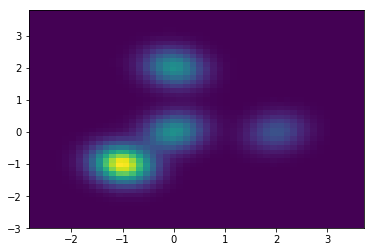

In [3]:
plt.hist2d(data[:,0], data[:,1], bins=50)

In [13]:
class VariationalAutoEncoder(object):
    def __init__(self, n_input_units, n_hidden_layers, n_hidden_units, n_latent_units,
                 learning_rate=0.005, batch_size=100, min_beta=1.0, max_beta=1.0,
                 distribution='normal'):
        self.n_input_units = n_input_units
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_units = n_hidden_units
        self.n_latent_units = n_latent_units
        self.learning_rate = learning_rate
        self.batch_size = int(batch_size)
        self.min_beta = min_beta
        self.max_beta = max_beta
        self.distribution = distribution

    class Encoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_latent_units, distribution):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_latent_units = n_latent_units
            self.distribution = distribution

        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []

        def add_hidden_layer(self, inputs):
            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]

        def add_mu(self, inputs):
            self.mu = tf.layers.Dense(units=self.n_latent_units)
            self.applied_mu = self.mu.apply(inputs)
            return self.applied_mu

        def add_sigma(self, inputs):
            if self.distribution == 'normal':
                units = self.n_latent_units
            elif self.distribution == 'vmf':
                units = 1
            else:
                raise NotImplemented
            self.sigma = tf.layers.Dense(units=units)
            self.applied_sigma = self.sigma.apply(inputs)
            return self.applied_sigma

        def build(self, inputs):
            self.init_hidden_layers()

            layer = self.add_hidden_layer(inputs)

            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)

            mu = self.add_mu(layer)
            sigma = self.add_sigma(layer)

            return mu, sigma

        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers
            ]

            mu = sess.run([self.mu.kernel, self.mu.bias])

            sigma = sess.run([self.sigma.kernel, self.sigma.bias])

            return layers, mu, sigma

    class Decoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_output_units):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_output_units = n_output_units

        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []

        def add_hidden_layer(self, inputs):
            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]

        def add_output(self, inputs):
            self.output = tf.layers.Dense(units=self.n_output_units)
            self.applied_output = self.output.apply(inputs)
            return self.applied_output

        def build(self, inputs):
            self.init_hidden_layers()

            layer = self.add_hidden_layer(inputs)

            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)

            output = self.add_output(layer)

            return output

        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers
            ]

            output = sess.run([self.output.kernel, self.output.bias])

            return layers, output

    def sampled_z(self, mu, sigma, batch_size):
        if self.distribution == 'normal':
            epsilon = tf.random_normal(tf.stack([int(batch_size), self.n_latent_units]))
            z = mu + tf.multiply(epsilon, tf.exp(0.5 * sigma))
        elif self.distribution == 'vmf':
            q_z = VonMisesFisher(mu, sigma)
            z = q_z.sample()
        else:
            raise NotImplemented

        return z

    def build_losses(self, x, output, mu, sigma):
        feature_loss = tf.reduce_sum(tf.squared_difference(x, output), 1)
        latent_loss = -0.5 * self.beta * tf.reduce_sum(1.0 + sigma - tf.square(mu) - tf.exp(sigma), 1)
        loss = tf.reduce_mean(feature_loss + latent_loss)
        return loss, feature_loss, latent_loss

    def initialize_tensors(self):
        self.x = tf.placeholder("float32", [self.batch_size, self.n_input_units])
        self.beta = tf.placeholder("float32", [1, 1])
        self.encoder = self.Encoder(self.n_hidden_layers, self.n_hidden_units, self.n_latent_units, 
                                    self.distribution)
        mu, sigma = self.encoder.build(self.x)
        self.mu = mu
        self.sigma = sigma
        self.z = self.sampled_z(self.mu, self.sigma, self.batch_size)
        self.decoder = self.Decoder(self.n_hidden_layers, self.n_hidden_units, self.n_input_units)
        self.output = self.decoder.build(self.z)
        loss, feature_loss, latent_loss = self.build_losses(self.x, self.output, self.mu, self.sigma)
        self.loss = loss
        self.feature_loss = feature_loss
        self.latent_loss = latent_loss

    def generate_beta_values(self, data_count, epochs):
        num_batches = int(data_count / self.batch_size)
        total_steps = (num_batches * epochs) - epochs
        beta_delta = self.max_beta - self.min_beta
        log_beta_step = 5 / float(total_steps)
        beta_values = [
            self.min_beta + (beta_delta * (1 - math.exp(-5 + (i * log_beta_step))))
            for i in range(total_steps)
        ]
        return beta_values

    def train_from_rdd(self, data_rdd, epochs=1):
        self.initialize_tensors()

        data_count = data_rdd.count()
        beta_values = self.generate_beta_values(data_count, epochs)

        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch_index in range(epochs):
                iterator = data_rdd.toLocalIterator()
                batch_index = 0
                while True:
                    batch = np.array(list(islice(iterator, self.batch_size)))
                    if batch.shape[0] == self.batch_size:
                        beta = beta_values.pop(0) if len(beta_values) > 0 else self.min_beta
                        feed_dict = {self.x: np.array(batch), self.beta: np.array([[beta]])}

                        if not batch_index % 100:
                            print("beta: {}".format(beta))
                            ls, f_ls, d_ls = sess.run([self.loss, self.feature_loss, self.latent_loss],
                                                      feed_dict=feed_dict)
                            print("loss={}, avg_feature_loss={}, avg_latent_loss={}".format(ls, np.mean(f_ls),
                                                                                            np.mean(d_ls)))
                            print('running batch {} in epoch {}'.format(batch_index, epoch_index))
                        sess.run(optimizer, feed_dict=feed_dict)
                        batch_index += 1
                    else:
                        print("incomplete batch: {}".format(batch.shape))
                        break

            print("evaluating model...")
            encoder_layers, eval_mu, eval_sigma = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)

        return VariationalAutoEncoderModel(encoder_layers, eval_mu, eval_sigma, decoder_layers, eval_output)

    def train(self, data, visualize=False, epochs=1):
        self.initialize_tensors()
        
        data_size = data.shape[0]
        batch_size = self.batch_size
        beta_values = self.generate_beta_values(data_size, epochs)

        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            i = 0
            while (i * batch_size) < data_size:
                batch = data[i * batch_size:(i + 1) * batch_size]
                beta = beta_values.pop(0) if len(beta_values) > 0 else self.min_beta
                feed_dict = {self.x: batch, self.beta: np.array([[beta]])}
                sess.run(optimizer, feed_dict=feed_dict)

                if visualize and (not i % int((data_size / batch_size) / 3) or i == int(data_size / batch_size) - 1):
                    ls, d, f_ls, d_ls = sess.run([self.loss, self.output, self.feature_loss, self.latent_loss],
                                                 feed_dict=feed_dict)
                    plt.scatter(batch[:, 0], batch[:, 1])
                    plt.show()
                    plt.scatter(d[:, 0], d[:, 1])
                    plt.show()
                    print(i, ls, np.mean(f_ls), np.mean(d_ls))

                i += 1

            encoder_layers, eval_mu, eval_sigma = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)

        return VariationalAutoEncoderModel(encoder_layers, eval_mu, eval_sigma, decoder_layers, eval_output)


class VariationalAutoEncoderModel(object):
    def __init__(self, encoder_layers, mu, sigma, decoder_layers, output):
        self.encoder = self.EncoderModel(encoder_layers, mu, sigma)
        self.decoder = self.DecoderModel(decoder_layers, output)

    def save(self, path):
        encoder_layers, encoder_mu, encoder_sigma = self.encoder.dump()
        decoder_layers, decoder_output = self.decoder.dump()
        serializable_model = (encoder_layers, encoder_mu, encoder_sigma, decoder_layers, decoder_output)
        pickle.dump(serializable_model, open(path, 'w+'))

    def encode(self, x):
        return self.encoder.encode(x)

    def project(self, x):
        return self.encoder.encode(x)[0]

    def decode(self, x):
        return self.decoder.decode(x)

    @classmethod
    def load(cls, path):
        return cls(*pickle.load(open(path, 'r')))

    class Layer(object):
        def __init__(self, kernel, bias, activation='linear'):
            self.kernel = kernel
            self.bias = bias
            self.activation = activation

        def dump(self):
            return (self.kernel, self.bias, self.activation)

        @property
        def apply_func(self):
            kernel, bias = self.kernel, self.bias

            linear = lambda inputs: np.matmul(inputs, kernel) + bias

            if self.activation == 'linear':
                f = linear
            elif self.activation == 'sigmoid':
                f = lambda inputs: 1 / (1 + np.exp(-linear(inputs)))

            return f

        def apply(self, inputs):
            return self.apply_func(inputs)

    class EncoderModel(object):
        def __init__(self, encoder_layers, mu, sigma):
            self.layers = [
                VariationalAutoEncoderModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in encoder_layers
            ]
            self.mu = VariationalAutoEncoderModel.Layer(*mu)
            self.sigma = VariationalAutoEncoderModel.Layer(*sigma)

        def dump(self):
            encoder_layers = [l.dump()[:2] for l in self.layers]
            encoder_mu = self.mu.dump()[:2]
            encoder_sigma = self.sigma.dump()[:2]
            return encoder_layers, encoder_mu, encoder_sigma

        def encode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.mu.apply(x), self.sigma.apply(x)

    class DecoderModel(object):
        def __init__(self, decoder_layers, output):
            self.layers = [
                VariationalAutoEncoderModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in decoder_layers
            ]
            self.output = VariationalAutoEncoderModel.Layer(*output)

        def dump(self):
            decoder_layers = [l.dump()[:2] for l in self.layers]
            decoder_output = self.output.dump()[:2]
            return decoder_layers, decoder_output

        def decode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.output.apply(x)


In [12]:
model = VariationalAutoEncoder(n_input_units=3, n_hidden_layers=2, n_hidden_units=9, n_latent_units=1, 
                               learning_rate=0.005, batch_size=50, distribution='normal')\
    .train(data, visualize=True)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_7' with dtype float and shape [1,1]
	 [[Node: Placeholder_7 = Placeholder[dtype=DT_FLOAT, shape=[1,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_7', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/opt/conda/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-cf6fdda5566a>", line 3, in <module>
    .train(data, visualize=True)
  File "<ipython-input-11-a3e764ca20de>", line 199, in train
    self.initialize_tensors()
  File "<ipython-input-11-a3e764ca20de>", line 134, in initialize_tensors
    self.beta = tf.placeholder("float32", [1, 1])
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4848, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_7' with dtype float and shape [1,1]
	 [[Node: Placeholder_7 = Placeholder[dtype=DT_FLOAT, shape=[1,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


(array([  9.90000000e+01,   1.37000000e+03,   1.12730000e+04,
          1.14196000e+05,   1.14187000e+05,   7.66040000e+04,
          5.16410000e+04,   3.64460000e+04,   2.60790000e+04,
          1.88520000e+04,   1.36100000e+04,   1.00560000e+04,
          7.34400000e+03,   5.29900000e+03,   3.70300000e+03,
          2.68100000e+03,   1.85200000e+03,   1.40500000e+03,
          9.85000000e+02,   7.22000000e+02,   5.06000000e+02,
          3.41000000e+02,   2.54000000e+02,   1.68000000e+02,
          1.23000000e+02,   9.00000000e+01,   8.90000000e+01,
          9.30000000e+01,   1.36000000e+02,   2.03000000e+02,
          3.30000000e+02,   5.87000000e+02,   1.10600000e+03,
          2.60600000e+03,   8.22900000e+03,   1.64695000e+05,
          6.56060000e+04,   4.34900000e+03,   1.26800000e+03,
          6.03000000e+02,   3.19000000e+02,   2.57000000e+02,
          2.31000000e+02,   2.27000000e+02,   2.83000000e+02,
          3.09000000e+02,   4.03000000e+02,   5.34000000e+02,
        

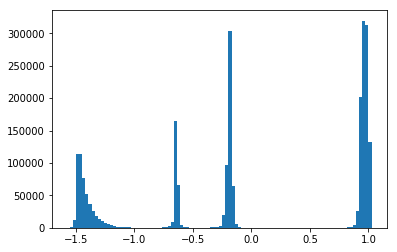

In [12]:
plt.hist(model.encoder.encode(data)[0], bins=100)

In [23]:
from sklearn.mixture import GaussianMixture



In [33]:
mus = model.encoder.encode(data)[0]

results = []

for i in range(1,10):
    m = GaussianMixture(i).fit(mus)
    results.append((i, m.score(mus), m.aic(mus), m.bic(mus)))

In [31]:
results

[(1, -1.349808787495403, 6074143.5437293136, 6074168.796610862),
 (2, -0.16352232973647432, 735860.4838141345, 735923.61601800541),
 (3, 0.2106959228959403, -948115.65303173137, -948014.6415055379),
 (4, 0.63413533432107461, -2853587.0044448357, -2853448.1135963197),
 (5, 0.65035754820199487, -2926580.9669089769, -2926404.1967381383),
 (6, 0.86345505427588054, -3885513.7442414626, -3885299.0947483014),
 (7, 0.79605181388766111, -3582193.162494475, -3581940.6336789913),
 (8, 0.8646548225404691, -3890900.7014321107, -3890610.2932943045),
 (9, 0.88927691745299919, -4001694.1285384963, -4001365.8410783675)]

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-1.5826096 , -1.52876103, -1.47491246, -1.42106389, -1.36721532,
        -1.31336675, -1.25951818, -1.20566961, -1.15182104, -1.09797247,
        -1.0441239 , -0.99027533, -0.93642676, -0.88257819, -0.82872962,
        -0.77488105, -0.72103248, -0.66718391, -0.61333534, -0.55948677,
        -0.5056382 , -0.45178963, -0.39794106, -0.34409249, -0.29024392,
        -0.23639535, -0.18254678, -0.12869821, -0.07484964, -0.02100107,
         0.0328475 ,  0.08669607,  0.14054464,  0.19439321,  0.24824178,
         0.30209035,  0.35593892,  0.40978749,  0.46363606,  0.51748463,
         0.5713332 ,  0.62518177,  0.67903034,  0.73287891,  0.78672748,
         0.84057605,  0.89442462,  0.94827319,  1.0021217

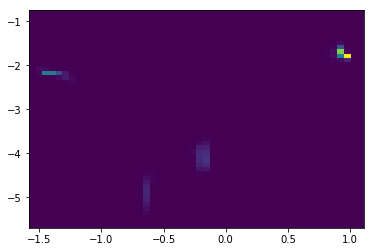

In [22]:
plt.hist2d(model.encoder.encode(data)[0].squeeze(1), model.encoder.encode(data)[1].squeeze(1), bins=50)